# Process data

In [2]:
import gzip
import json
import math
import random
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm 

In [ ]:

# Process entire dataset if needed

def process_reviews():
    dataset = []
    path = "Electronics.jsonl.gz"

    with gzip.open(path, 'rt', encoding="utf8") as f:
        total_lines = sum(1 for _ in f)

    with gzip.open(path, 'rt', encoding="utf8") as f:
        for line in tqdm(f, total=total_lines, desc="Processing reviews"):
            d = json.loads(line.strip())
            processed_review = {
                'user_id': d['user_id'],
                'rating': int(float(d['rating'])),
                'helpful_vote': int(d['helpful_vote']),
                'timestamp': int(d['timestamp']),
                'asin': d['asin'],
                'text': d['text'],
                'title': d['title'],
                'parent_asin': d['parent_asin'],
                'verified_purchase': d['verified_purchase']
            }
            dataset.append(processed_review)
    
    return dataset

# Process sample of dataset

def process_reviews_sample(sample_size=100000):
   dataset = []
   path = "Electronics.jsonl.gz"
   
   with gzip.open(path, 'rt', encoding="utf8") as f:
       for i, line in tqdm(enumerate(f), total=sample_size, desc="Processing sample"):
           if i >= sample_size:
               break
           d = json.loads(line.strip())
           processed_review = {
               'user_id': d['user_id'],
               'rating': int(float(d['rating'])),
               'helpful_vote': int(d['helpful_vote']),
               'timestamp': int(d['timestamp']),
               'asin': d['asin'],
               'text': d['text'],
               'title': d['title'],
               'parent_asin': d['parent_asin'],
               'verified_purchase': d['verified_purchase']
           }
           dataset.append(processed_review)
   
   return dataset

# Process and save full dataset

full_dataset = process_reviews()
df = pd.DataFrame(full_dataset)
df.to_parquet('processed_electronics.parquet')

Processing reviews: 100%|██████████████████████████████████████████████| 43886944/43886944 [06:05<00:00, 120045.94it/s]


In [1]:
import gzip
import json
import pandas as pd
from tqdm import tqdm

def process_and_save_reviews(chunk_size=50000):
    """
    Process and save the data in smaller chunks to manage memory
    """
    path = "Electronics.jsonl.gz"
    chunk_counter = 0
    chunk = []
    
    # First count total lines
    print("Counting total lines...")
    with gzip.open(path, 'rt', encoding="utf8") as f:
        total_lines = sum(1 for _ in f)
    
    print(f"Processing {total_lines:,} reviews in chunks of {chunk_size:,}")
    
    # Process in chunks
    with gzip.open(path, 'rt', encoding="utf8") as f:
        for i, line in tqdm(enumerate(f), total=total_lines):
            d = json.loads(line.strip())
            processed_review = {
                'user_id': d['user_id'],
                'rating': int(float(d['rating'])),
                'helpful_vote': int(d['helpful_vote']),
                'timestamp': int(d['timestamp']),
                'asin': d['asin'],
                'text': d['text'],
                'title': d.get('title', ''),
                'parent_asin': d.get('parent_asin', ''),
                'verified_purchase': d['verified_purchase']
            }
            chunk.append(processed_review)
            
            # Save chunk when it reaches the chunk_size
            if len(chunk) >= chunk_size:
                df = pd.DataFrame(chunk)
                df.to_parquet(f'chunks/chunk_{chunk_counter}.parquet')
                chunk = []  # Clear chunk
                chunk_counter += 1
                
    # Save any remaining reviews
    if chunk:
        df = pd.DataFrame(chunk)
        df.to_parquet(f'chunk_{chunk_counter}.parquet')
    
    print(f"Processing complete! Saved {chunk_counter + 1} chunks.")

# Run the processing
process_and_save_reviews()

Counting total lines...
Processing 43,886,944 reviews in chunks of 50,000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 43886944/43886944 [04:25<00:00, 165085.06it/s]

Processing complete! Saved 878 chunks.


In [3]:
import glob

# Get all chunk files from the chunks folder
chunks = glob.glob('chunks/chunk_*.parquet')
# Load and combine all chunks
df = pd.concat([pd.read_parquet(f) for f in chunks])

# Exploratory analysis

Loading chunks...
Loaded 877 chunks, total 43,850,000 reviews

Basic Statistics:
count    4.385000e+07
mean     4.099481e+00
std      1.412131e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


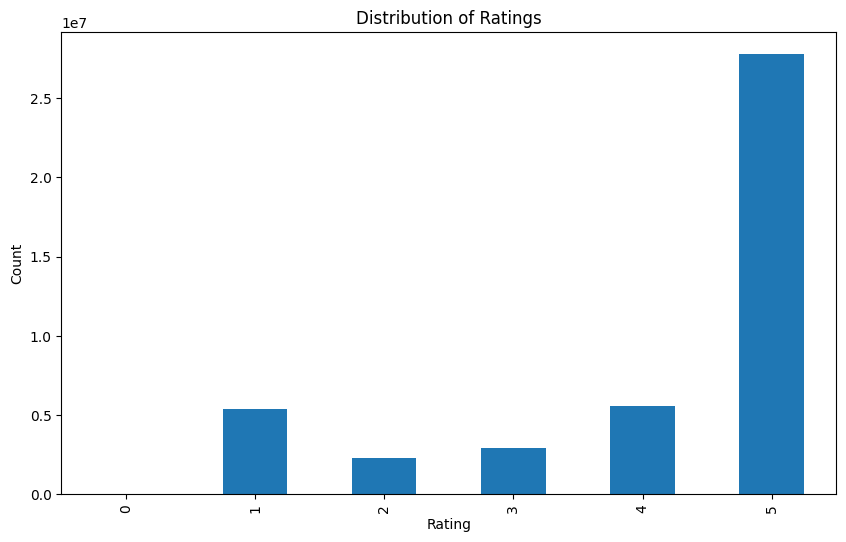

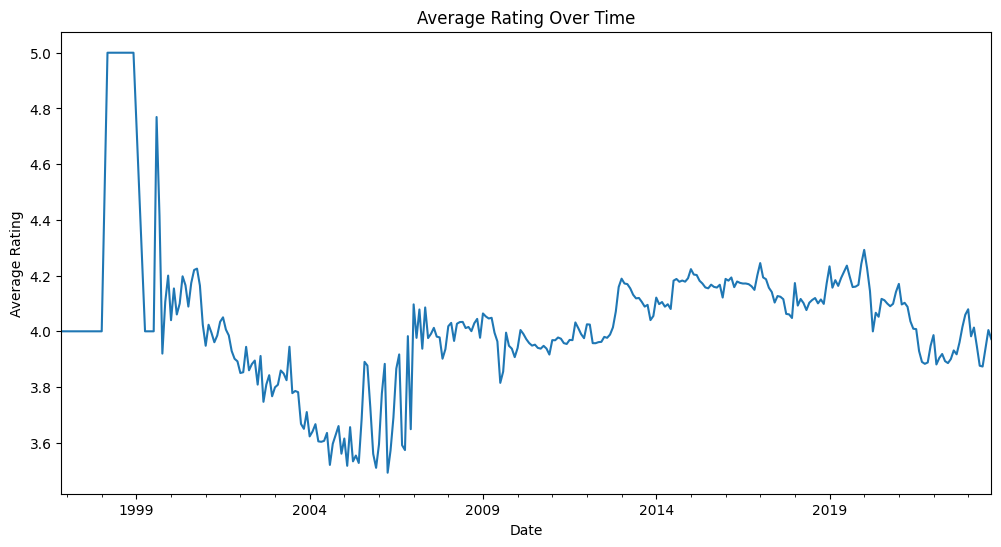


Helpful Votes Statistics:
count    4.385000e+07
mean     1.090535e+00
std      2.258447e+01
min     -4.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.684100e+04
Name: helpful_vote, dtype: float64

Average Rating by Verified Purchase:
verified_purchase
False    3.822335
True     4.122305
Name: rating, dtype: float64

User Review Statistics:
count    1.825637e+07
mean     2.401901e+00
std      3.927539e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.034000e+03
Name: count, dtype: float64


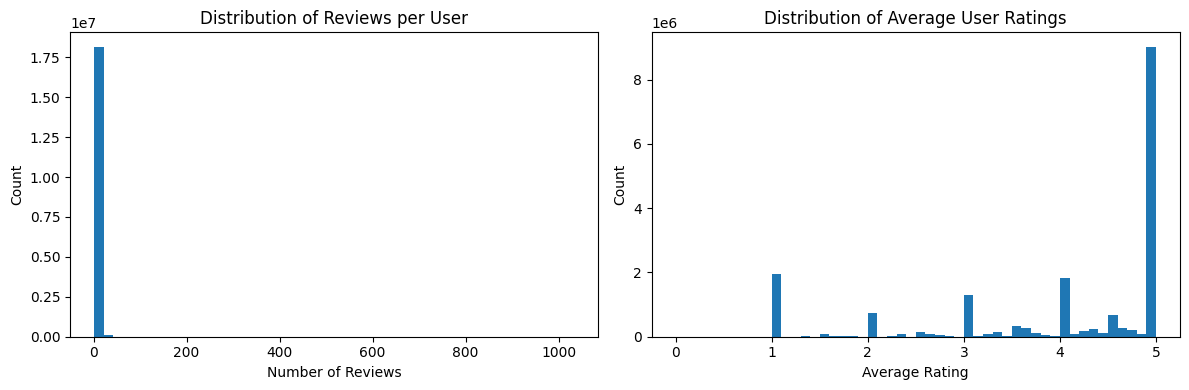

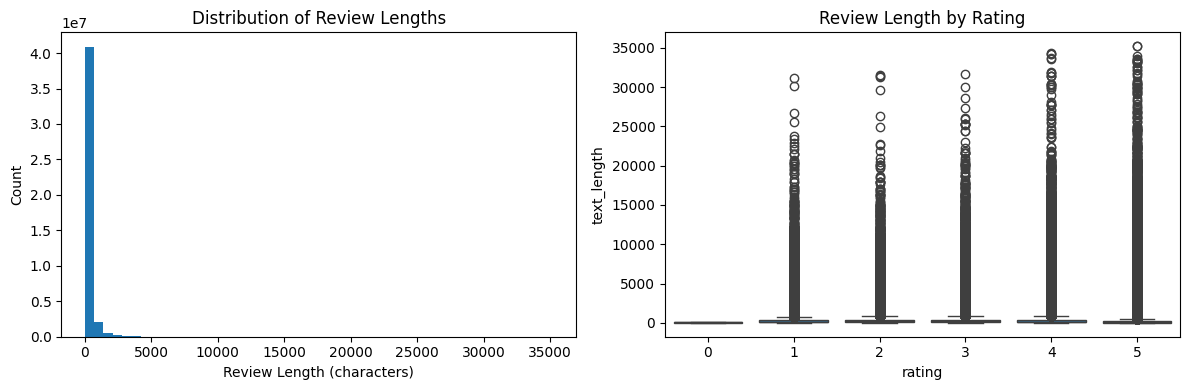


Text Length Statistics:
count    4.385000e+07
mean     2.413575e+02
std      4.194510e+02
min      0.000000e+00
25%      4.800000e+01
50%      1.220000e+02
75%      2.710000e+02
max      3.520800e+04
Name: text_length, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Load all chunks from the chunks folder
print("Loading chunks...")
chunks = glob.glob('chunks/chunk_*.parquet')
df = pd.concat([pd.read_parquet(f) for f in chunks], ignore_index=True)
print(f"Loaded {len(chunks)} chunks, total {len(df):,} reviews")

# The rest of your analysis code remains the same, just remove the DataFrame conversion
# since we already have a DataFrame

# Basic statistics
print("\nBasic Statistics:")
print(df['rating'].describe())

# Rating distribution
plt.figure(figsize=(10, 6))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Average rating over time
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
monthly_ratings = df.groupby(df['date'].dt.to_period('M'))['rating'].mean()
plt.figure(figsize=(12, 6))
monthly_ratings.plot(kind='line')
plt.title('Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.show()

# Helpful votes analysis
print("\nHelpful Votes Statistics:")
print(df['helpful_vote'].describe())

# Verified vs unverified purchase ratings
print("\nAverage Rating by Verified Purchase:")
print(df.groupby('verified_purchase')['rating'].mean())

# User Analysis
user_review_counts = df['user_id'].value_counts()
user_avg_ratings = df.groupby('user_id')['rating'].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(user_review_counts, bins=50)
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
print("\nUser Review Statistics:")
print(user_review_counts.describe())

plt.subplot(1, 2, 2)
plt.hist(user_avg_ratings, bins=50)
plt.title('Distribution of Average User Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Review Text Analysis
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(x='rating', y='text_length', data=df)
plt.title('Review Length by Rating')
plt.tight_layout()
plt.show()

print("\nText Length Statistics:")
print(df['text_length'].describe())

# Correlation between text length and helpful votes
correlation = df['text_length'].corr(df['helpful_vote'])
print(f"\nCorrelation between review length and helpful votes: {correlation:.3f}")

# Product Analysis
product_review_counts = df['asin'].value_counts()
product_avg_ratings = df.groupby('asin')['rating'].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(product_review_counts, bins=50)
plt.title('Distribution of Reviews per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(product_avg_ratings, bins=50)
plt.title('Distribution of Average Product Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\nProduct Statistics:")
print(f"Total unique products: {df['asin'].nunique()}")
print("\nReviews per product:")
print(product_review_counts.describe())

# Time analysis
df['year'] = df['date'].dt.year
yearly_counts = df.groupby('year').size()
yearly_ratings = df.groupby('year')['rating'].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
yearly_counts.plot(kind='bar')
plt.title('Number of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')

plt.subplot(1, 2, 2)
yearly_ratings.plot(kind='bar')
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

# Verified Purchase Analysis
verified_stats = df.groupby('verified_purchase').agg({
    'rating': ['count', 'mean', 'std'],
    'helpful_vote': 'mean',
    'text_length': 'mean'
}).round(2)

print("\nVerified Purchase Analysis:")
print(verified_stats)

# Overall Summary Statistics
summary_stats = {
    'Total Reviews': len(df),
    'Unique Users': df['user_id'].nunique(),
    'Unique Products': df['asin'].nunique(),
    'Average Rating': df['rating'].mean(),
    'Median Rating': df['rating'].median(),
    'Average Review Length': df['text_length'].mean(),
    'Verified Purchase %': (df['verified_purchase'] == 'Y').mean() * 100,
    'Average Helpful Votes': df['helpful_vote'].mean()
}

print("\nOverall Summary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value:.2f}")

# The Predictor

In [16]:
import gzip
import math
import matplotlib.pyplot as plt
import numpy
import random
import sklearn
import string
from collections import defaultdict
from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
#from transformers import AutoTokenizer, AutoModel

In [17]:
df.head()

,user_id,rating,helpful_vote,timestamp,asin,text,title,parent_asin,verified_purchase,date,text_length,year
0,AHFK7E6OMEWWPNWGBGWJCGAAB4TQ,5,0,1536070749785,B01M334NVP,I love the fact that this product shuts the Ki...,Love the on/off feature,B01M334NVP,True,2018-09-04 14:19:09.785,141,2018
1,AHFK7E6OMEWWPNWGBGWJCGAAB4TQ,5,0,1532210033293,B01GEW27DA,Bought this as a Christmas gift and our grandd...,Granddaughter loves it,B07P374FF3,True,2018-07-21 21:53:53.293,151,2018
2,AHFK7E6OMEWWPNWGBGWJCGAAB4TQ,5,0,1532209729717,B00RPWO3W2,I like this product because it handles chargin...,Very handy,B07LBRZ5TH,True,2018-07-21 21:48:49.717,129,2018
3,AHFK7E6OMEWWPNWGBGWJCGAAB4TQ,5,0,1449800645000,B00HBPWQE0,This is the second Supcase product I have used...,The screen protector is snug and the feel of t...,B01HCHVUOS,True,2015-12-11 02:24:05.000,423,2015
4,AHFK7E6OMEWWPNWGBGWJCGAAB4TQ,5,0,1420731204000,B0006I1TRY,Was an upgrade and it helped a lot. Crucial pr...,Crucial products and website are good.,B0006I1TRY,True,2015-01-08 15:33:24.000,74,2015


In [19]:
#reviews = [d['text'] for d in data] #array of each review's text.
#ratings = [d['rating'] for d in data] #array of each review's rating.
reviews = df['text']
ratings = df['rating']

In [ ]:
reviewTokens = [] #lists the token words for each review.

In [22]:
punctuation = set(string.punctuation)

# Function to tokenize the text
def tokenize(t):
    # Remove punctuation
    r = ''.join([c for c in t.lower() if not c in punctuation])
    # Tokenize
    tokens = []
    for w in r.split():
        tokens.append(w)
    return tokens

In [ ]:
# Tokenize the review text
df['text'] = df['text'].apply(tokenize)

In [ ]:
# Create a word2vec embedding from the review text
model = Word2Vec(df['text'],
                 min_count=5, # Words/items with fewer instances are discarded
                 vector_size=10, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model

In [ ]:
def get_doc_vector(review, model_w2v):
    vectors = [model_w2v.wv[word] for word in review if word in model_w2v.wv]
    return numpy.mean(vectors, axis=0) if vectors else numpy.zeros(model_w2v.vector_size)

In [ ]:
feature_vector = [get_doc_vector(review, model) for review in reviews]

In [ ]:
X = [[1]+list(f) for f in feature_vector]

#X_train, X_test, y_train, y_test = train_test_split(X, ratings, test_size=0.2, random_state=42)
model_lr = sklearn.linear_model.Ridge(1, fit_intercept=False)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}") 

In [ ]:
model_lr.coef_

In [ ]:
from transformers import AutoTokenizer, AutoModel

model_name = "bert-base-uncased"  # Choose a pre-trained model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

text = "This is an example sentence."
inputs = tokenizer(text, return_tensors="pt") 
outputs = model(**inputs)
embeddings = outputs.last_hidden_state  # Access the embeddings

## Using BERT models from Google to embed the review text

In [180]:
dfs=df.sample(frac=0.00001)

In [181]:
dfs['text'].head

<bound method NDFrame.head of 11734979                                   Listen to it daily
13560954    Adds depth that you can feel to your music wit...
23850930    My hopes were super high coming into this. My ...
26123137       Great cable, solved our video latency problem.
11685274    This one gets a bit slow on my Nikon D800 shoo...
                                  ...                        
37019406    I really like this emergency radio. It seems t...
40994551    I was pleasantly surprised by the design and b...
37568724                              Exactly what was needed
27503434    I would give this NO stars if at all possible ...
28036894    I use this for work.  It holds what I need it ...
Name: text, Length: 439, dtype: object>

In [182]:
len(dfs)

439

In [190]:
extractor.tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [193]:
from transformers import pipeline, AutoTokenizer, AutoModel

model_name = "bert-base-uncased"  # Choose a pre-trained model
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModel.from_pretrained(model_name)

extractor = pipeline(
    'feature-extraction', # We're just interested in the embeddings
    model=model_name, # Use BERT
    device=0 # Use the GPU
#    truncation=True,
#    max_lenght=512
)

# A function to embed text from our dataframe
def embed(t):
    # Since we are using a BERT model, we can just use the first "word" embedding, which represents the entire text
    # This model has a limit of 512, so we will use a strategy to take N/2 from the head and N/2 from the tail
    extra_words = len(t) - 512
    if(extra_words > 0):
        return extractor(t[:256] + t[-256:])[0][0]
    else:
        return extractor(t)[0][0]

# Still in development. Not sure if this will be faster...
def fastembed(texts):
    # Texts is a list of texts. This is called batching, and it's more
    # efficient than running two separate embedding calls.
    embeddings = extractor(texts,truncation=True, max_length=512)

    # Since we are using a BERT model, we can just use the first "word" embedding,
    # which represents the entire text, so that's why we're returning embedding[0][0]
    return [embedding[0][0] for embedding in embeddings]


In [ ]:
# This is how you embed one piece of text at a time.
embed("I hate this product with a passion! It sucks balls! I would never ever buy it")

In [ ]:
# This is how you would batch the embedding of the title and the review simultaneously
fastembed(["Don't buyt this!", "I hate this product with a passion! It sucks balls! I would never ever buy it"])

In [166]:
import time

In [194]:
# Embed the review text
start_time = time.perf_counter()
dfs['embedding_review'] = dfs['text'].apply(embed)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


#dfs['embedding_review'] = dfs['text'].apply(embed)
#dfs['embedding_title'] = dfs['title'].apply(embed)

Elapsed time: 9.611691792000784 seconds


In [164]:
type(dfs['text'])

pandas.core.series.Series

In [184]:
start_time = time.perf_counter()
dfs['embeding_review'] = list(map(fastembed,dfs['text'].tolist()))
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 10.326073625008576 seconds


In [173]:
dfs['embedding_review']

4704864     [-0.10075164586305618, -0.20883628726005554, 0...
23620863    [-0.44238004088401794, -0.17166751623153687, -...
16596390    [-0.2668057978153229, -0.20451557636260986, 0....
32233131    [-0.4351918399333954, -0.1979217231273651, 0.5...
22885243    [0.0014428598806262016, 0.48619088530540466, 0...
                                  ...                        
38893538    [0.19444310665130615, 0.237596333026886, 0.259...
43001902    [-0.5732800364494324, 0.14354920387268066, 0.0...
25016606    [-0.3044198155403137, -0.25239214301109314, 0....
14766650    [-0.0039941780269145966, -0.2644607126712799, ...
39102361    [-0.87104731798172, -0.7027274370193481, 0.205...
Name: embedding_review, Length: 439, dtype: object

In [ ]:
dfs['embedding_title']

In [162]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Total size of data
N = len(dfs)

X = [[1]+ fvs[0] + fvs[1] for fvs in zip(dfs['embedding_review'],dfs['embedding_title'])]
y = dfs['rating']

Ntrain,Nvalid,Ntest = int(N*0.8), int(N*0.1), int(N*0.1)
X_train,X_valid,X_test = X[:Ntrain],X[Ntrain:Ntrain+Nvalid],X[Ntrain+Nvalid:]
y_train,y_valid,y_test = y[:Ntrain],y[Ntrain:Ntrain+Nvalid],y[Ntrain+Nvalid:]

model_lr = sklearn.linear_model.Ridge(1, fit_intercept=False)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
print(f"Mean Squared Error: {mse}") 

Mean Squared Error: 0.6363165360163489
